In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

PROJECT_ROOT = Path.cwd().parent  # assuming notebook is in ./notebooks/
DATA_DIR = PROJECT_ROOT / "data"

BASE = 'XOM'
CANDIDATE = 'DE'

test_start = '2024-07-01'
test_end = '2025-06-30'

test_prices_df =      pd.read_csv(DATA_DIR / f"./raw/prices_test.csv")
train_prices_df =     pd.read_csv(DATA_DIR / f"./raw/prices_train.csv")
benchmarks_df =       pd.read_csv(DATA_DIR / "./raw/benchmark_prices.csv")
test_signals_df =     pd.read_csv(DATA_DIR / f"./processed/test_signals_{BASE}_{CANDIDATE}.csv")
train_signals_df =    pd.read_csv(DATA_DIR / f"./processed/train_signals_{BASE}_{CANDIDATE}.csv")
strategy_returns_df = pd.read_csv(DATA_DIR / f"./processed/strategy_returns_{BASE}_{CANDIDATE}.csv")

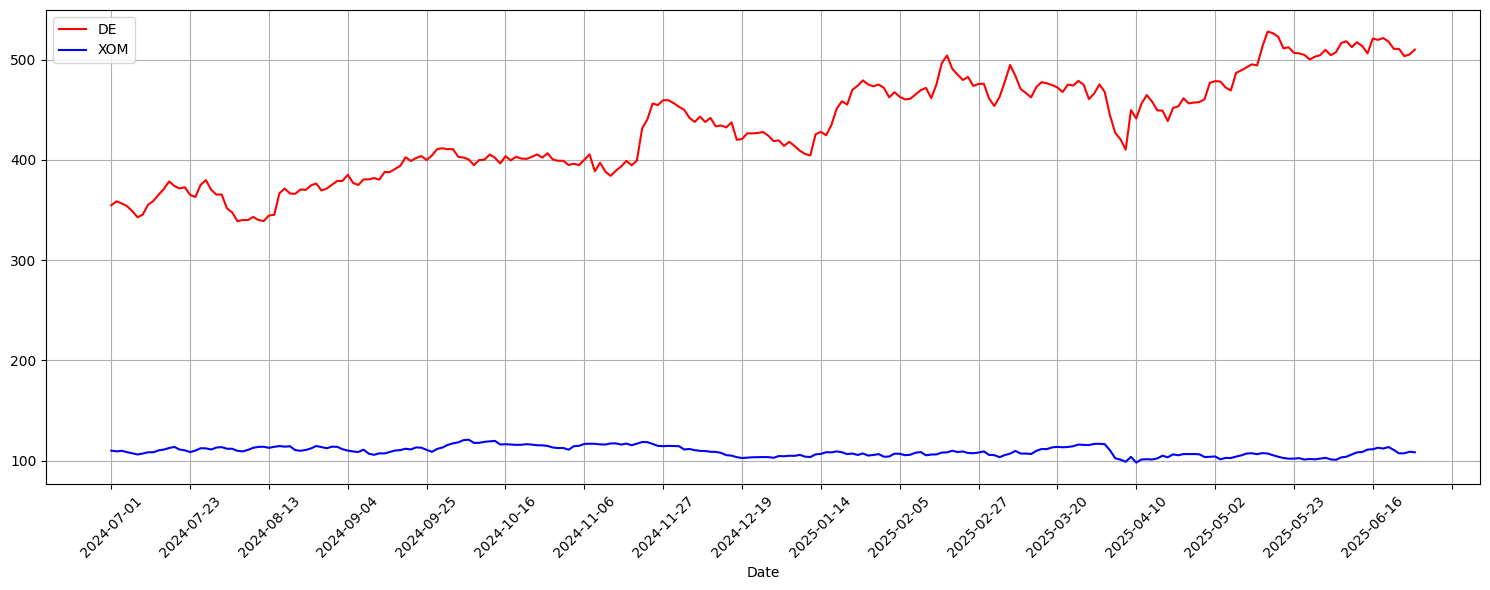

In [2]:
# Define base and candidate, test and train dataframes
base_test = test_prices_df[test_prices_df['Ticker'] == BASE]
base_train = train_prices_df[train_prices_df['Ticker'] == BASE]
candidate_test = test_prices_df[test_prices_df['Ticker'] == CANDIDATE]
candidate_train = train_prices_df[train_prices_df['Ticker'] == CANDIDATE]

# Plot train or test time series'
plt.figure(figsize=(15, 6))
plt.plot(candidate_test['Date'], candidate_test['Close'], label=CANDIDATE, color='red')
plt.plot(base_test['Date'], base_test['Close'], label=BASE, color='blue')
plt.xlabel("Date")
plt.grid(True)

plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


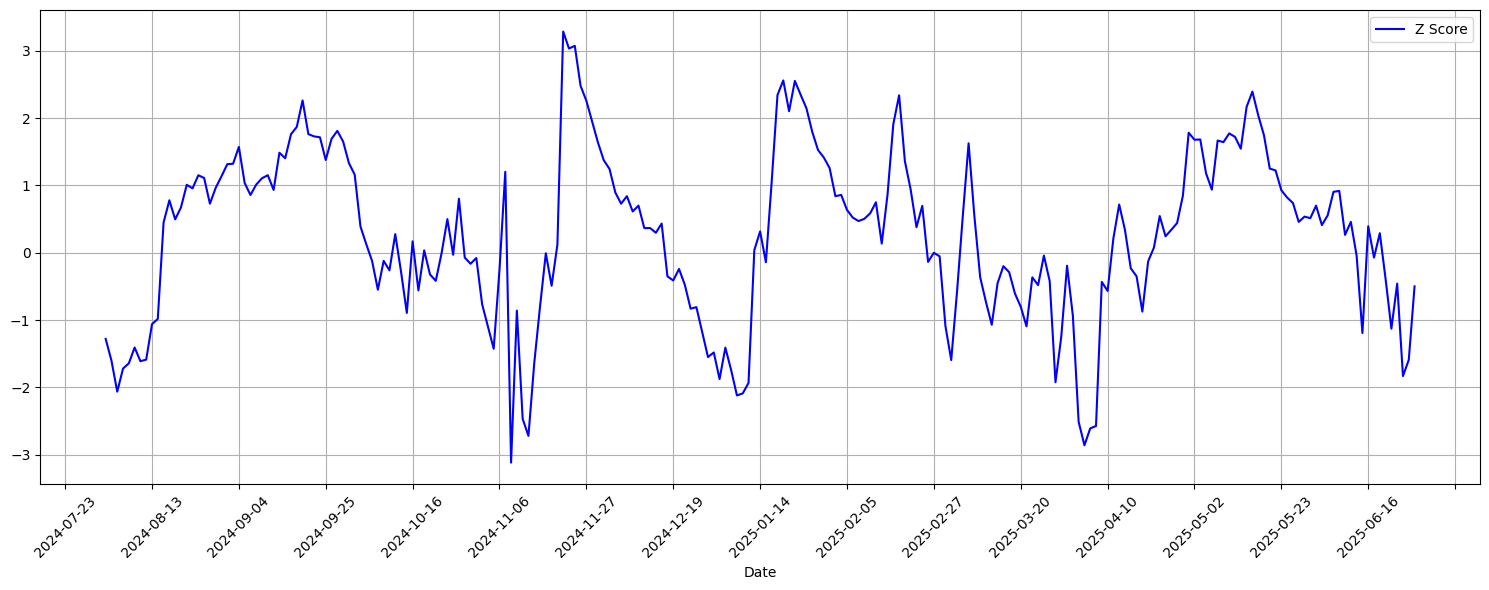

In [3]:
# Plot the spread and z_score for given pair
plt.figure(figsize=(15, 6))
plt.plot(test_signals_df['Date'], test_signals_df['Z_score'], label="Z Score", color='blue')
plt.xlabel("Date")
plt.grid(True)

plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

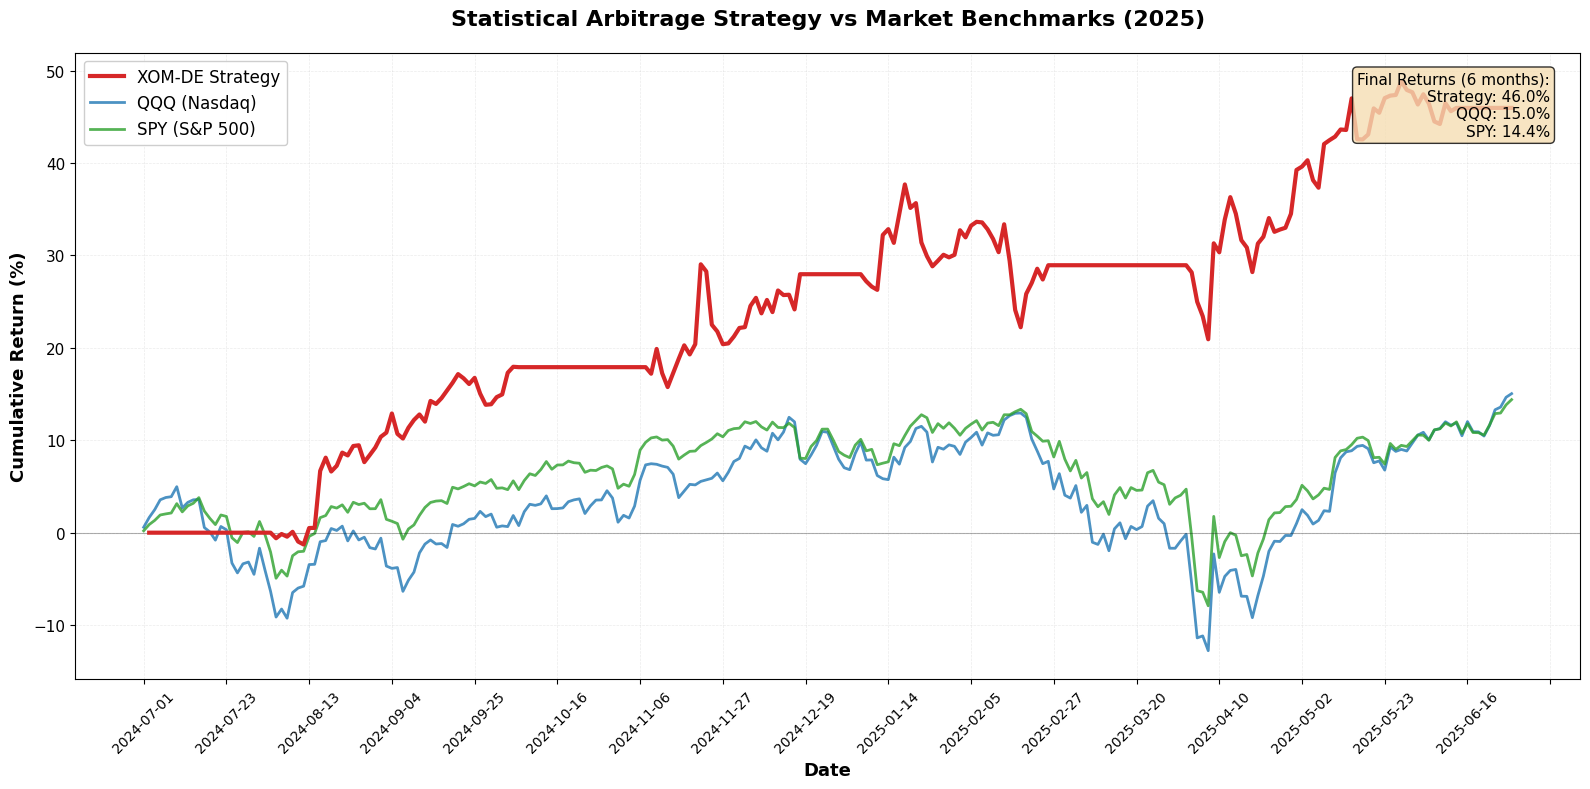

In [4]:
# Trim data to only show test period
strategy_returns_df = strategy_returns_df[(strategy_returns_df['Date'] >= test_start) & (strategy_returns_df['Date'] <= test_end)]
benchmarks_df  = benchmarks_df[(benchmarks_df['Date'] >= test_start) & (benchmarks_df['Date'] <= test_end)]

qqq_df = benchmarks_df[benchmarks_df['Ticker'] == 'QQQ'].copy()
spy_df = benchmarks_df[benchmarks_df['Ticker'] == 'SPY'].copy()

# Compute cummulative returns for strategy and benchmarks
strategy_returns_df['Cumulative_Return'] = (1 + strategy_returns_df['Ret']).cumprod() - 1
qqq_df['Cumulative_Return'] = (1 + qqq_df['Ret']).cumprod() - 1
spy_df['Cumulative_Return'] = (1 + spy_df['Ret']).cumprod() - 1


fig, ax = plt.subplots(figsize=(16, 8))

# Plot with better styling
ax.plot(strategy_returns_df['Date'], strategy_returns_df['Cumulative_Return'] * 100, 
        linewidth=3, label=f'{BASE}-{CANDIDATE} Strategy', color='#d62728', zorder=3)  # Red, on top
ax.plot(qqq_df['Date'], qqq_df['Cumulative_Return'] * 100, 
        linewidth=2, label='QQQ (Nasdaq)', color='#1f77b4', alpha=0.8)  # Blue
ax.plot(spy_df['Date'], spy_df['Cumulative_Return'] * 100, 
        linewidth=2, label='SPY (S&P 500)', color='#2ca02c', alpha=0.8)  # Green

# Add horizontal line at 0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

# Formatting
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Cumulative Return (%)', fontsize=13, fontweight='bold')
ax.set_title('Statistical Arbitrage Strategy vs Market Benchmarks (2025)', 
             fontsize=16, fontweight='bold', pad=20)

# Legend
ax.legend(loc='upper left', fontsize=12, framealpha=0.95)

# Grid
ax.grid(True, alpha=0.25, linestyle='--', linewidth=0.5)

# Format x-axis dates
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)
plt.yticks(fontsize=11)

# Add annotation for final values
final_strategy = strategy_returns_df['Cumulative_Return'].iloc[-1] * 100
final_spy = spy_df['Cumulative_Return'].iloc[-1] * 100
final_qqq = qqq_df['Cumulative_Return'].iloc[-1] * 100

ax.text(0.98, 0.97, 
        f'Final Returns (6 months):\n'
        f'Strategy: {final_strategy:.1f}%\n'
        f'QQQ: {final_qqq:.1f}%\n'
        f'SPY: {final_spy:.1f}%',
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

In [5]:
# Ensure Date column is datetime
strategy_returns_df['Date'] = pd.to_datetime(strategy_returns_df['Date'])

# Define windows
start_date = strategy_returns_df['Date'].min()
mid_date = start_date + pd.DateOffset(months=6)
end_date = strategy_returns_df['Date'].max()

# Split dataframes
first_half = strategy_returns_df[strategy_returns_df['Date'] < mid_date]
second_half = strategy_returns_df[strategy_returns_df['Date'] >= mid_date]
full_year = strategy_returns_df

# Function to calculate metrics
def calc_metrics(df):
    returns = df['Ret'].dropna()
    total_return = df['Cumulative_Return'].iloc[-1]
    volatility = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
    return total_return, sharpe, volatility

# Calculate for each window
windows = {'First 6 Months': first_half, 'Last 6 Months': second_half, 'Full Year': full_year}

for name, df in windows.items():
    total_ret, sharpe, vol = calc_metrics(df)
    print(f"\n{name}:")
    print(f"  Total Return: {total_ret:.2%}")
    print(f"  Sharpe Ratio: {sharpe:.2f}")
    print(f"  Volatility: {vol:.2%}")


First 6 Months:
  Total Return: 27.97%
  Sharpe Ratio: 2.60
  Volatility: 19.54%

Last 6 Months:
  Total Return: 45.96%
  Sharpe Ratio: 1.25
  Volatility: 24.19%

Full Year:
  Total Return: 45.96%
  Sharpe Ratio: 1.86
  Volatility: 21.90%
